In [ ]:
from google.colab import files

# This will prompt you to upload the kaggle.json file
files.upload()

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d shayanfazeli/heartbeat
!unzip heartbeat.zip -d heartbeat_data
!ls heartbeat_data

Dataset URL: https://www.kaggle.com/datasets/shayanfazeli/heartbeat
License(s): unknown
  0% 0.00/98.8M [00:00<?, ?B/s]
100% 98.8M/98.8M [00:00<00:00, 1.39GB/s]
Archive:  heartbeat.zip
  inflating: heartbeat_data/mitbih_test.csv  
  inflating: heartbeat_data/mitbih_train.csv  
  inflating: heartbeat_data/ptbdb_abnormal.csv  
  inflating: heartbeat_data/ptbdb_normal.csv  
mitbih_test.csv  mitbih_train.csv  ptbdb_abnormal.csv  ptbdb_normal.csv


In [ ]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
train_df = pd.read_csv('heartbeat_data/mitbih_train.csv')
test_df = pd.read_csv('heartbeat_data/mitbih_test.csv')

In [ ]:
target_col = train_df.columns[-1]
train_df.isna().any().any()

np.False_

In [ ]:
train_df[target_col].value_counts()

,count
0.000000000000000000e+00.88,
0.0,72470
4.0,6431
2.0,5788
1.0,2223
3.0,641


In [ ]:
#train_df[target_col] = train_df[target_col].astype('int')
#train_df[target_col].head()

In [ ]:
N_SAMPLES = 20000

# Resample
df0 = train_df[train_df[target_col]==0]
df1 = train_df[train_df[target_col]==1]
df2 = train_df[train_df[target_col]==2]
df3 = train_df[train_df[target_col]==3]
df4 = train_df[train_df[target_col]==4]


df0_resampled = resample(df0, replace=False, n_samples=N_SAMPLES, random_state=42)
df1_resampled = resample(df1, replace=True, n_samples=N_SAMPLES, random_state=42)
df2_resampled = resample(df2, replace=True, n_samples=N_SAMPLES, random_state=42)
df3_resampled = resample(df3, replace=True, n_samples=N_SAMPLES, random_state=42)
df4_resampled = resample(df4, replace=True, n_samples=N_SAMPLES, random_state=42)


In [ ]:
train_df = pd.concat([df0_resampled, df1_resampled, df2_resampled, df3_resampled, df4_resampled])
train_df[target_col].value_counts()

,count
0.000000000000000000e+00.88,
0.0,20000
1.0,20000
2.0,20000
3.0,20000
4.0,20000


In [ ]:
# Convert to tensors
X_train_pd = train_df.iloc[:, :-1].values
y_train_pd = train_df.iloc[:, -1].values
X_test_pd = test_df.iloc[:, :-1].values
y_test_pd = test_df.iloc[:, -1].values

X_train = torch.tensor(X_train_pd, dtype = torch.float32).unsqueeze(1)
y_train = torch.tensor(y_train_pd, dtype = torch.long)
X_test = torch.tensor(X_test_pd, dtype = torch.float32).unsqueeze(1)
y_test = torch.tensor(y_test_pd, dtype = torch.long)

print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([100000, 1, 187]) torch.Size([100000])
torch.Size([21891, 1, 187]) torch.Size([21891])


In [ ]:
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)

In [ ]:
BATCH_SIZE = 64
# Data loaders
train_loader = DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle=False)

In [ ]:
class_model = nn.Sequential(
     # 1
    nn.Conv1d(in_channels=1, out_channels=64, kernel_size=5, padding='same'),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),

    # 2
    nn.Conv1d(64, 128, kernel_size=3, padding='same'),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),

    # 3
    nn.Conv1d(128, 256, kernel_size=3, padding='same'),
    nn.BatchNorm1d(256),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),

    # 4
    nn.Conv1d(256, 128, kernel_size=3, padding='same'),
    nn.BatchNorm1d(128),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),

    # 5
    nn.Conv1d(128, 64, kernel_size=3, padding='same'),
    nn.BatchNorm1d(64),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),

    # Flatten + Dense layers
    nn.Flatten(),
    nn.Linear(320, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, 5)
)

class_model.to(device)
print(class_model)

Sequential(
  (0): Conv1d(1, 64, kernel_size=(5,), stride=(1,), padding=same)
  (1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU()
  (3): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (4): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=same)
  (5): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (6): ReLU()
  (7): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (8): Conv1d(128, 256, kernel_size=(3,), stride=(1,), padding=same)
  (9): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (10): ReLU()
  (11): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (12): Conv1d(256, 128, kernel_size=(3,), stride=(1,), padding=same)
  (13): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (14): ReLU()
  (15): MaxPool1d(kernel_size=2, stride=2, padding=0, dila

In [ ]:
# Class Weights
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_pd), y=y_train_pd)
class_weights = torch.tensor(class_weights, dtype=torch.float32).to(device)

criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = torch.optim.Adam(class_model.parameters(), lr=0.001)

In [ ]:
EPOCHS = 50


train_losses = []
test_losses = []
test_accuracies = []
best_test_loss = float('inf')

for epoch in range(EPOCHS):
  # Training
  class_model.train()
  running_loss = 0.0
  for inputs, labels in train_loader:
    inputs, labels = inputs.to(device), labels.to(device)
    optimizer.zero_grad()
    outputs = class_model(inputs)
    loss = criterion(outputs, labels)
    loss.backward()
    optimizer.step()
    running_loss += loss.item()
  train_losses.append(running_loss/len(train_loader))

  # Validation
  class_model.eval()
  val_loss = 0.0
  correct=0
  total=0
  with torch.no_grad():
    for inputs, labels in test_loader:
      inputs, labels = inputs.to(device), labels.to(device)
      outputs = class_model(inputs)
      loss = criterion(outputs, labels)
      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    current_val_loss = val_loss / len(test_loader)
    test_losses.append(current_val_loss)
    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

  print(f'Epoch {epoch+1}/{EPOCHS}, Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_loss:.4f}, Test Accuracy: {accuracy:.2f}%')
  if test_losses[-1] < best_test_loss:
      best_test_loss = test_losses[-1]
      torch.save(class_model.state_dict(), 'best_model.pth')

print('Done')

Epoch 1/50, Train Loss: 0.0021, Val Loss: 70.0246, Test Accuracy: 98.21%
Epoch 2/50, Train Loss: 0.0036, Val Loss: 60.2946, Test Accuracy: 98.34%
Epoch 3/50, Train Loss: 0.0021, Val Loss: 72.5421, Test Accuracy: 97.88%
Epoch 4/50, Train Loss: 0.0028, Val Loss: 62.3305, Test Accuracy: 98.40%
Epoch 5/50, Train Loss: 0.0028, Val Loss: 67.2255, Test Accuracy: 98.06%
Epoch 6/50, Train Loss: 0.0026, Val Loss: 76.4927, Test Accuracy: 97.86%
Epoch 7/50, Train Loss: 0.0025, Val Loss: 60.6769, Test Accuracy: 98.43%
Epoch 8/50, Train Loss: 0.0034, Val Loss: 65.5532, Test Accuracy: 98.22%
Epoch 9/50, Train Loss: 0.0029, Val Loss: 63.1217, Test Accuracy: 98.31%
Epoch 10/50, Train Loss: 0.0025, Val Loss: 69.0197, Test Accuracy: 98.25%
Epoch 11/50, Train Loss: 0.0026, Val Loss: 68.0042, Test Accuracy: 98.25%
Epoch 12/50, Train Loss: 0.0036, Val Loss: 64.6101, Test Accuracy: 98.31%
Epoch 13/50, Train Loss: 0.0024, Val Loss: 67.2944, Test Accuracy: 98.53%
Epoch 14/50, Train Loss: 0.0026, Val Loss: 85.3


--- Final Classification Report ---
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     18117
           1       0.77      0.87      0.82       556
           2       0.97      0.95      0.96      1448
           3       0.78      0.86      0.82       162
           4       0.99      0.99      0.99      1608

    accuracy                           0.98     21891
   macro avg       0.90      0.93      0.92     21891
weighted avg       0.98      0.98      0.98     21891



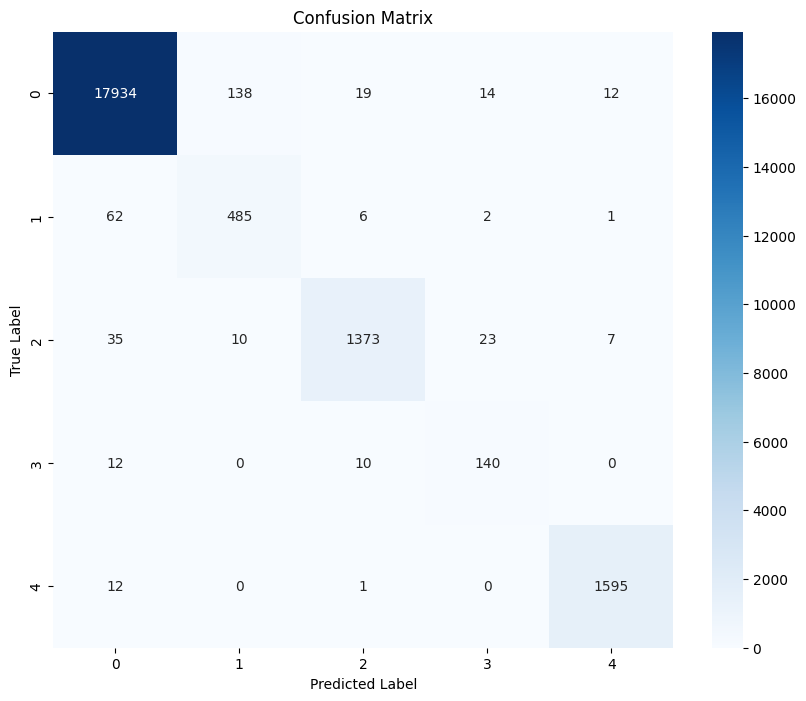

In [ ]:
# Load the best model weights
class_model.load_state_dict(torch.load('best_model.pth'))
class_model.eval()

y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = class_model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# --- Classification Report ---
print("\n--- Final Classification Report ---")
print(classification_report(y_true, y_pred))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()